# **Librerie**

In [1]:
pip install selectivesearch

  Preparing metadata (setup.py) ... - \ done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4335 sha256=b36bd1cc566f783b619f8194eb1719dd28fea18494182da647cdc14098562f15
  Stored in directory: /root/.cache/pip/wheels/0e/49/95/01447a4e0f48a135ac91fbdb1dd2a1c0523e40e29957b383a3
Successfully built selectivesearch
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio.v3 as imageio
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import cv2
import shutil
import json
import yaml
import random
import time
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import concurrent.futures
import multiprocessing as mp
from PIL import Image, ImageOps
from collections import defaultdict, Counter
from torchvision import transforms
from torchvision.transforms import functional as TF
import torch.optim as optim
import re
import selectivesearch
import torch.optim as optim
from torchvision import models
from torchvision.models import AlexNet_Weights
import matplotlib.patches as mpatches
import torch.nn.functional as F
from sklearn.svm import SVC

# **Dataset Preprocessing**

Il nostro dataset è xView, un'analisi preliminare del dataset è presente nel [documento](https://medium.com/picterra/the-xview-dataset-and-baseline-results-5ab4a1d0f47f) linkato.


Questo dataset rappresentava il migliore per il benchmarking di visione artificiale satellitare. La documentazione tecnica spiega che i dati sono ottenuti dai satelliti **WorldView-3**, con una distanza di campionamento al suolo uniforme di 0,3 metri. Ciò conferisce una risoluzione più elevata e omogenea rispetto alla maggior parte degli altri dataset satellitari esistenti all'epoca, molti dei quali si basano invece su fotografie aeree. Quest'ultime, infatti, presentano differenze nella distorsione causate dall'angolo di ripresa, poiché sono scattate da velivoli a bassa quota. 

Il dataset **xView** offre una copertura geografica ampia e diversificata, includendo anche aree meno sviluppate e urbanizzate, fornendo quindi una maggiore varietà di scenari rispetto a dataset più convenzionali. 

### Elenco delle categorie del dataset:  

#### 0-3: Velivoli  
- 0: Fixed-wing Aircraft  
- 1: Small Aircraft  
- 2: Passenger/Cargo Plane  
- 3: Helicopter  

#### 4-15: Veicoli terrestri  
- 4: Passenger Vehicle  
- 5: Small Car  
- 6: Bus  
- 7: Pickup Truck  
- 8: Utility Truck  
- 9: Truck  
- 10: Cargo Truck  
- 11: Truck Tractor w/ Box Trailer  
- 12: Truck Tractor  
- 13: Trailer  
- 14: Truck Tractor w/ Flatbed Trailer  
- 15: Truck Tractor w/ Liquid Tank  

#### 16: Veicoli speciali  
- 16: Crane Truck  

#### 17-22: Veicoli ferroviari  
- 17: Railway Vehicle  
- 18: Passenger Car  
- 19: Cargo/Container Car  
- 20: Flat Car  
- 21: Tank car  
- 22: Locomotive  

#### 23-32: Imbarcazioni  
- 23: Maritime Vessel  
- 24: Motorboat  
- 25: Sailboat  
- 26: Tugboat  
- 27: Barge  
- 28: Fishing Vessel  
- 29: Ferry  
- 30: Yacht  
- 31: Container Ship  
- 32: Oil Tanker  

#### 33-45: Veicoli da costruzione/industriali  
- 33: Engineering Vehicle  
- 34: Tower crane  
- 35: Container Crane  
- 36: Reach Stacker  
- 37: Straddle Carrier  
- 38: Mobile Crane  
- 39: Dump Truck  
- 40: Haul Truck  
- 41: Scraper/Tractor  
- 42: Front loader/Bulldozer  
- 43: Excavator  
- 44: Cement Mixer  
- 45: Ground Grader  

#### 46-51: Edifici e strutture  
- 46: Hut/Tent  
- 47: Shed  
- 48: Building  
- 49: Aircraft Hangar  
- 50: Damaged Building  
- 51: Facility  

#### 52-59: Altre infrastrutture  
- 52: Construction Site  
- 53: Vehicle Lot  
- 54: Helipad  
- 55: Storage Tank  
- 56: Shipping container lot  
- 57: Shipping Container  
- 58: Pylon  
- 59: Tower  

Utilizziamo un processo di preprocessing per il dataset **xView** seguendo i passi presenti in questo [Notebook (Preprocessing)](https://www.kaggle.com/code/ollypowell/xview-dataset-to-yolo-and-coco-format). L'obiettivo è:

1. **Pulizia e riformattazione**: Si parte dal dataset grezzo e lo si prepara per l'addestramento di modelli di intelligenza artificiale per il rilevamento di oggetti.
2. **Suddivisione in chunck**: Poiché le immagini satellitari sono molto grandi, vengono suddivise in "pezzi" più piccoli (chunck) per facilitare l'elaborazione. I bounding box, che definiscono le posizioni degli oggetti nelle immagini, vengono ridimensionati in modo che corrispondano ai nuovi pezzi.
3. **Ottimizzazione del formato**: Le immagini TIFF, che occupano molto spazio, vengono convertite in formato JPG, molto più leggero.
4. **Personalizzazione**: È possibile scegliere la dimensione delle immagini finali e come suddividere i dati per l'addestramento.

Questo processo riduce significativamente la dimensione del dataset, rendendolo più gestibile, senza sacrificare le informazioni necessarie per l'addestramento di modelli come **YOLOv5**.


Dopo aver analizzato le considerazioni riportate durante l'analisi esplorativa del dataset nel seguente [Notebook (Exploratory Data Analysis)](https://www.kaggle.com/code/ollypowell/xview-1-dataset-eda?scriptVersionId=157247786), abbiamo deciso di apportare alcune modifiche al preprocessing originale descritto nel documento linkato.

In particolare, abbiamo osservato che circa il 41% delle porzioni (chunk) di immagini con dimensioni comprese tra 600x600 e 640x640 risultavano prive di label. Questo è un problema, poiché il dataset originale è stato costruito raccogliendo immagini contenenti almeno una label. Per migliorare la qualità del dataset, abbiamo scelto di suddividere le immagini originali in chunk più piccoli, di dimensioni 320x320, ed eliminare il 66% delle immagini prive di label. Questo approccio ci ha permesso di ottenere un dataset composto per circa il 70% da immagini contenenti oggetti da identificare e per il 30% da immagini vuote. L'obiettivo è ottenere un training della rete più coerente ed efficace.

Inoltre, abbiamo corretto alcuni errori nel preprocessing originale, che impedivano di escludere i chunk con dimensioni inferiori a una certa soglia, errori nei path della working space ed altri.

La scelta di utilizzare chunk più piccoli si basa sulla considerazione che suddividere le immagini in parti di dimensioni ridotte consente di massimizzare la probabilità di includere tutte le label presenti nel dataset originale. Inoltre, ciò facilita la visualizzazione degli oggetti da individuare, sia per l'algoritmo che per un osservatore umano.

Abbiamo infine deciso di escludere i chunk con dimensioni comprese nell'intervallo [300x300, 320x320), poiché rappresentavano una quantità trascurabile rispetto al totale. Gestirli avrebbe richiesto ulteriori scelte progettuali, come l'applicazione di tecniche di stretching sia sulle immagini sia sulle coordinate geometriche delle label, con un impatto complessivo marginale sull'efficacia del modello.

Nel seguente codice sono inoltre presenti molte operazioni di debug e di check per evitare che errori nella fase di preprocessing si ripercuotano sul successivo training.

## Setup

In [3]:
#Data sources
DATA_FLDR_NM = 'Data'
IN_DATASET_NM = 'xview-dataset'
IMAGE_FLDR_NM = 'train_images'
IN_LABELS_FLDR_NM = 'train_labels'
LABELS_XML_NM = 'xView_train.geojson'

#Output folders and file names
OUT_DATASET_NM = 'xview-yolo-dataset'
CLASS_MAP_JSON_NM = 'xView_class_map.json'
OUT_COCO_JSON_NM = 'COCO_annotations.json'
OUT_IMAGE_FLDR_NM = 'images'
OUT_CFG_FLDR_NM = 'YOLO_cfg'
OUT_DATAFRAME_NM = 'xview_labels.parquet'
YAML_NM = 'xview_yolo.yaml'
CHUNK_WIDTH = 320  # width of the images being created
CHUNK_HEIGHT = 320
MIN_CHUNK_HEIGHT = 320 # no images will be kept if the image chunk is smaller than this
MIN_CHUNK_WIDTH = 320
IMAGE_WRITING = True #True to re-perform image cropping, False just to regenerated other data
TEST_FRACTION = 0.1
JPEG_COMPRESSION = 95 # For the saved files
VAL_FRACTION = 0.1
RANDOM_SEED = 2023
DEBUG = False

in_dataset_pth = Path('/kaggle/input/xview-dataset')
out_dataset_pth = Path('/kaggle/working/')
future_ds_img_fldr = Path(f'/kaggle/working/{OUT_IMAGE_FLDR_NM}')
future_ds_cfg_fldr = Path(f'/kaggle/working/{OUT_CFG_FLDR_NM}')

labels_json_pth = in_dataset_pth / IN_LABELS_FLDR_NM / LABELS_XML_NM
img_fldr_pth = in_dataset_pth / IMAGE_FLDR_NM / IMAGE_FLDR_NM
save_images_fldr_pth = out_dataset_pth / OUT_IMAGE_FLDR_NM 
out_data_parquet_pth = out_dataset_pth / OUT_DATAFRAME_NM
out_json_map_pth = out_dataset_pth / CLASS_MAP_JSON_NM 
class_map_pth = out_dataset_pth / CLASS_MAP_JSON_NM
cfg_fldr_pth = out_dataset_pth / OUT_CFG_FLDR_NM
coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM
yolo_yaml_pth = cfg_fldr_pth / YAML_NM
train_txt_pth = cfg_fldr_pth / 'train.txt'
val_txt_pth = cfg_fldr_pth / 'val.txt'
test_txt_pth = cfg_fldr_pth / 'test.txt'

def make_empty_dir(directory):
    if directory.is_dir():
        shutil.rmtree(directory)
    os.makedirs(directory)

make_empty_dir(cfg_fldr_pth)
if IMAGE_WRITING:
    make_empty_dir(save_images_fldr_pth)

random.seed(RANDOM_SEED)

print(f'The input images are found at {cfg_fldr_pth}')
print(f'The input labels are found at  {labels_json_pth}')
print(f'Configuration files will be saved to {cfg_fldr_pth}')
print(f'YOLO image files will be saved to {save_images_fldr_pth}')

The input images are found at /kaggle/working/YOLO_cfg
The input labels are found at  /kaggle/input/xview-dataset/train_labels/xView_train.geojson
Configuration files will be saved to /kaggle/working/YOLO_cfg
YOLO image files will be saved to /kaggle/working/images


## Helper Functions

In [4]:
# Estrae i bounding box da un DataFrame, eventualmente filtrandoli per una lista di classi
def get_boxes(in_df, class_lst=[]):
    if class_lst:
        in_df = in_df[in_df['TYPE_ID'].isin(class_lst)]     # Filtra il DataFrame per le classi specificate
    unique_images = in_df.IMAGE_ID.unique().tolist()        # Ottiene una lista unica di ID immagine
    boxs = {}

    for image in tqdm_notebook(unique_images):
        mask = in_df['IMAGE_ID'] == image                                  # Seleziona solo le righe relative a una specifica immagine
        masked = in_df[mask][['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX']]  # Estrae solo le colonne richieste
        boxs[image] = masked.values.tolist()                               # Converte i valori in lista e li salva nel dizionario
    return boxs


# Stampa le prime n righe di un file di testo
def print_first_n_lines(file_path, n):
    try:
        with open(file_path, 'r') as file:
            for line_num, line in enumerate(file, 1):
                if line_num > n:                  
                    break
                print(line.strip()) 
    except FileNotFoundError:
        print('Unable to open file')        


# Carica un'immagine per la visualizzazione (convertita da BGR a RGB)
def load_image(file_pth):
    image_obj = cv2.imread(file_pth)                        
    image_obj = cv2.cvtColor(image_obj, cv2.COLOR_BGR2RGB)  
    return image_obj


# Carica un'immagine per la sola elaborazione (BGR)
def load_bgr_image(file_pth):
    image_obj = cv2.imread(file_pth)  
    return image_obj


# Mostra una lista di immagini con i bounding box disegnati sopra
def display_images(image_lst, boxes_dictionary, image_fldr, max_images=6, no_cols=1, text=False, class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims // no_cols + (display_ims % no_cols > 0)                   # Calcola il numero di righe necessarie
    fig, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))  # Crea il layout della griglia
    axs = axs.flatten()                                                              # Appiattisce l'array degli assi

    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = str(image_fldr / img_nm)  
        img = load_image(image_path)  

        # Disegna i bounding box sull'immagine
        if img_nm in boxes_dictionary:
            for box in boxes_dictionary[img_nm]:
                box_id, x_min, y_min, x_max, y_max = box
                x_min, y_min, x_max, y_max = int(x_min), int(y_max), int(x_max), int(y_min)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)      # Disegna il rettangolo
                if text:
                    if class_map:
                        box_label = class_map[box_id]                                 # Mappa la classe
                    else:
                        box_label = str(box_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)  # Scrive il testo

        axs[k].set_title(f"Image {img_nm}", fontsize=12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    plt.tight_layout()
    plt.show()
    return


# Converte le coordinate YOLO in coordinate per OpenCV ((left, top), (right, bottom))
def get_corners(x_cen, y_cen, an_width, an_height, im_width, im_height):
    x_cen, y_cen, an_width, an_height = float(x_cen), float(y_cen), float(an_width), float(an_height)
    # Calcolo dei margini
    left = (x_cen - an_width/2)*im_width            
    top = (y_cen - an_height/2)*im_height           
    right = (x_cen + an_width/2)*im_width           
    bottom = (y_cen + an_height/2)*im_height        
    return int(left), int(top), int(right), int(bottom)


# Mostra immagini con bounding box definiti in formato YOLO
def display_yolo_images(image_lst, image_fldr, max_images=6, no_cols=1, text=False, class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims // no_cols + (display_ims % no_cols > 0)
    _, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()

    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = image_fldr / img_nm
        text_fn = image_path.stem + '.txt'     # Costruisce il nome del file dei bounding box
        boxes_path = image_fldr / text_fn
        img = load_image(str(image_path))  
        im_h, im_w, _ = img.shape  
        with open(boxes_path) as text_file:
            annotations = [line.rstrip().split() for line in text_file]  

        # Disegna i bounding box
        for ann in annotations:
            class_id = ann[0]
            x_centre, y_centre, w, h = ann[1], ann[2], ann[3], ann[4]
            x_min, y_min, x_max, y_max = get_corners(x_centre, y_centre, w, h, im_w, im_h)
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
            if text:
                if class_map:
                    box_label = class_map[int(class_id)]
                else:
                    box_label = str(class_id)
                cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        axs[k].set_title(f"Image {img_nm}", fontsize=12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    plt.tight_layout()
    plt.show()
    return


# Trova i bounding box contenuti in una sezione dell'immagine e li restituisce in formato YOLO
def match_boxes(box_list, chnk_lims):
    boxes_lists = []
    le, to = chnk_lims[0], chnk_lims[1]                    # Limiti del chunk (left, top)
    w, h = chnk_lims[2], chnk_lims[3]                      # Larghezza e altezza del chunk
    for box in box_list:
        o_left, o_top, o_right, o_bottom = box[1], box[2], box[3], box[4]
        left, right = (o_left - le)/w, (o_right - le)/w    # Normalizza rispetto ai limiti del chunk
        top, bottom = (o_top - to)/h, (o_bottom - to)/h

        # Verifica se il bounding box è contenuto nella sezione
        h_match = (0 <= left < 1) or (0 < right <= 1)
        v_match = (0 <= top < 1) or (0 < bottom <= 1)

        if v_match and h_match:
            clipped = np.clip([left, top, right, bottom], a_min=0, a_max=1)  # Clippa i valori tra 0 e 1
            l, t, r, b = clipped[0], clipped[1], clipped[2], clipped[3]
            bounding_box = [str(box[0]),
                            str(round((l + r)/2, 5)),
                            str(round((t + b)/2, 5)),
                            str(round(r - l, 5)),
                            str(round(b - t, 5))]       # Formatta in YOLO
            boxes_lists.append(bounding_box)
    return boxes_lists

## Data Extraction and Cleaning

In [5]:
# Apre un file JSON contenente annotazioni e carica i dati
with open(labels_json_pth, 'r') as infile:
    data = json.load(infile)                        # Carica il file JSON in un dizionario
    keys = list(data.keys())                        # Estrazioni delle chiavi del dizionario

# Estrae la lista delle annotazioni (features) dal JSON
feature_list = data['features']

# Definisce le colonne per il DataFrame
COLUMNS = ['IMAGE_ID', 'TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX', 'LONG', 'LAT']

data = []
for feature in tqdm_notebook(feature_list):  
    properties = feature['properties']               # Estrae le proprietà del feature (dizionario)
    img_id = properties['image_id']                  # Identificativo immagine
    type_id = properties['type_id']                  # Tipo di oggetto annotato
    bbox = properties['bounds_imcoords'].split(",")  # Coordinate del bounding box

    geometry = feature['geometry']  
    coords = geometry['coordinates'][0]              # Lista di coordinate (lista di liste)

    # Calcola il punto centrale geografico 
    long = coords[0][0] / 2 + coords[2][0] / 2       # Media delle longitudini dei vertici opposti
    lat = coords[0][1] / 2 + coords[1][1] / 2        # Media delle latitudini dei vertici opposti

    # Crea una riga con tutte le informazioni rilevanti
    one_row = [img_id, type_id, bbox[0], bbox[1], bbox[2], bbox[3], long, lat]
    data.append(one_row)  

# Conta il numero di istanze totali nel dataset
instances = len(data)
print(f'Ci sono {instances} istanze degli ogetti nel dataset originale')

  0%|          | 0/601937 [00:00<?, ?it/s]

Ci sono 601937 istanze degli ogetti nel dataset originale


Estrazione delle colonne di interesse:

In [6]:
df = pd.DataFrame(data, columns = COLUMNS)
df[['XMIN', 'YMIN', 'XMAX', 'YMAX']] = df[['XMIN', 'YMIN', 'XMAX', 'YMAX']].apply(pd.to_numeric)
df.head()

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


Rimozione di 2 annotation errate per le class labels ([EDA](https://www.kaggle.com/code/ollypowell/xview-dataset-eda))

In [7]:
df = df[(df.TYPE_ID != 75) & (df.TYPE_ID != 82)]   # removing erroneous labels
print(f'{instances - len(df)} rows removed, leaving {len(df)} rows')

79 rows removed, leaving 601858 rows


In [8]:
df.head()

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


Rimozione dell'immagine 1395, poiché inesistente

In [9]:
old_length = len(df)
df = df[df.IMAGE_ID != '1395.tif']
print(f'{old_length - len(df)} rows removed, leaving {len(df)}')
df.head()

131 rows removed, leaving 601727


,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


Inoltre, è utile convertire gli ID dei tipi in una sequenza continua da 0 a 59 per le 60 categorie. Le label originali della competizione non erano organizzate in questo modo. Il dizionario riportato di seguito rappresenta la mappatura originale:

In [10]:
old_dict = {
    11:'Fixed-wing Aircraft', 12:'Small Aircraft', 13:'Passenger/Cargo Plane', 15:'Helicopter',
    17:'Passenger Vehicle', 18:'Small Car', 19:'Bus', 20:'Pickup Truck', 21:'Utility Truck',
    23:'Truck', 24:'Cargo Truck', 25:'Truck Tractor w/ Box Trailer', 26:'Truck Tractor',27:'Trailer',
    28:'Truck Tractor w/ Flatbed Trailer', 29:'Truck Tractor w/ Liquid Tank', 32:'Crane Truck',
    33:'Railway Vehicle', 34:'Passenger Car', 35:'Cargo/Container Car', 36:'Flat Car', 37:'Tank car',
    38:'Locomotive', 40:'Maritime Vessel', 41:'Motorboat', 42:'Sailboat', 44:'Tugboat', 45:'Barge',
    47:'Fishing Vessel', 49:'Ferry', 50:'Yacht', 51:'Container Ship', 52:'Oil Tanker',
    53:'Engineering Vehicle', 54:'Tower crane', 55:'Container Crane', 56:'Reach Stacker',
    57:'Straddle Carrier', 59:'Mobile Crane', 60:'Dump Truck', 61:'Haul Truck', 62:'Scraper/Tractor',
    63:'Front loader/Bulldozer', 64:'Excavator', 65:'Cement Mixer', 66:'Ground Grader', 71:'Hut/Tent',
    72:'Shed', 73:'Building', 74:'Aircraft Hangar', 76:'Damaged Building', 77:'Facility', 79:'Construction Site',
    83:'Vehicle Lot', 84:'Helipad', 86:'Storage Tank', 89:'Shipping container lot', 91:'Shipping Container',
    93:'Pylon', 94:'Tower'}

Di seguito si aggiorna la mappatura delle label

In [11]:
old_keys = sorted(list(old_dict.keys()))
new_dict = {old_dict[x]:y for y, x in enumerate(old_keys)}
class_map_dict = {y:old_dict[x] for y, x in enumerate(old_keys)}
with open(out_json_map_pth, "w") as json_file:
    json.dump(class_map_dict, json_file)
print(class_map_dict)

{0: 'Fixed-wing Aircraft', 1: 'Small Aircraft', 2: 'Passenger/Cargo Plane', 3: 'Helicopter', 4: 'Passenger Vehicle', 5: 'Small Car', 6: 'Bus', 7: 'Pickup Truck', 8: 'Utility Truck', 9: 'Truck', 10: 'Cargo Truck', 11: 'Truck Tractor w/ Box Trailer', 12: 'Truck Tractor', 13: 'Trailer', 14: 'Truck Tractor w/ Flatbed Trailer', 15: 'Truck Tractor w/ Liquid Tank', 16: 'Crane Truck', 17: 'Railway Vehicle', 18: 'Passenger Car', 19: 'Cargo/Container Car', 20: 'Flat Car', 21: 'Tank car', 22: 'Locomotive', 23: 'Maritime Vessel', 24: 'Motorboat', 25: 'Sailboat', 26: 'Tugboat', 27: 'Barge', 28: 'Fishing Vessel', 29: 'Ferry', 30: 'Yacht', 31: 'Container Ship', 32: 'Oil Tanker', 33: 'Engineering Vehicle', 34: 'Tower crane', 35: 'Container Crane', 36: 'Reach Stacker', 37: 'Straddle Carrier', 38: 'Mobile Crane', 39: 'Dump Truck', 40: 'Haul Truck', 41: 'Scraper/Tractor', 42: 'Front loader/Bulldozer', 43: 'Excavator', 44: 'Cement Mixer', 45: 'Ground Grader', 46: 'Hut/Tent', 47: 'Shed', 48: 'Building', 49

Ora possiamo convertire i vecchi **TYPE_ID** del dataframe nei loro nuovi valori

In [12]:
df['TYPE_ID'] = df['TYPE_ID'].apply(lambda x: new_dict[old_dict[x]])
df.head(3)

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,48,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,48,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,48,2687,1338,2740,1399,-90.531694,14.565379


Per verificare che i dati vengano caricati correttamente, visualizziamo alcune immagini con eventuali annotazioni relative ai trasporti

  0%|          | 0/786 [00:00<?, ?it/s]

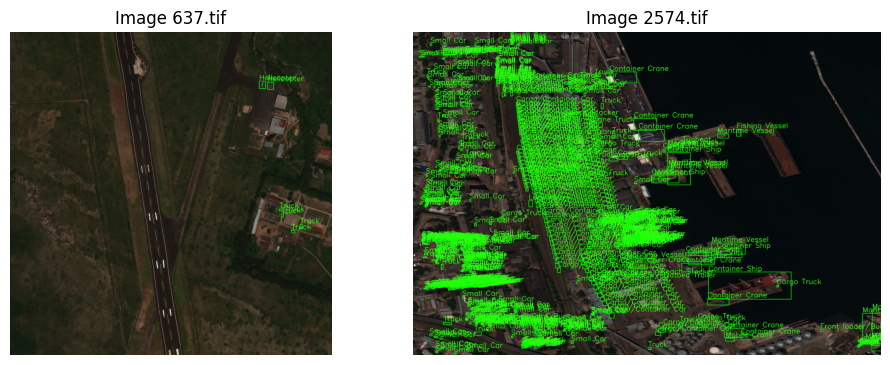

In [13]:
all_classes = list(class_map_dict.keys())
transport_only = [x for x in all_classes if x < 48]

boxes = get_boxes(df, transport_only)
images_for_display = random.choices(list(boxes.keys()), k=2)
display_images(images_for_display, boxes, img_fldr_pth, max_images=2, no_cols=2, text=True, class_map=class_map_dict) #adjust as desired

## Chunk Processing
- Suddividere i file TIFF di grandi dimensioni in chunk  
- Salvare questi chunk come file JPG  
- Verificare se i chunk contengono annotazioni  
- Riformattare le annotazioni nel formato YOLO: x_center, y_center, width, height (tutto normalizzato)  
- Scrivere tutte le annotazioni in formato YOLO in un dizionario, utilizzando il nome del file come chiave  

In [14]:
boxes_dict = get_boxes(df)  # Dizionario: {filename:[['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX'],[..],[..],..]}

  0%|          | 0/846 [00:00<?, ?it/s]

In [15]:
def process_image(img_fn, 
                  dir_pth=img_fldr_pth, 
                  boxes=boxes_dict, 
                  out_dir=save_images_fldr_pth, 
                  c_height=CHUNK_HEIGHT, 
                  c_width=CHUNK_WIDTH,  
                  jpg_q=JPEG_COMPRESSION,
                  min_h=MIN_CHUNK_HEIGHT,
                  min_w=MIN_CHUNK_WIDTH,
                  writing=IMAGE_WRITING
                 ):
    """
    Suddivide un'immagine in piccoli chunk, salva i chunk in formato JPEG e converte le annotazioni in formato YOLO.

    Args:
        img_fn (str): Nome del file immagine da processare.
        dir_pth (Path): Percorso della directory contenente le immagini di input.
        boxes (dict): Dizionario che associa ogni immagine a una lista di annotazioni.
        out_dir (Path): Percorso della directory dove salvare i chunk generati.
        c_height (int): Altezza dei chunk da creare.
        c_width (int): Larghezza dei chunk da creare.
        jpg_q (int): Qualità di compressione JPEG (valore da 0 a 100).
        min_h (int): Altezza minima per considerare un chunk valido.
        min_w (int): Larghezza minima per considerare un chunk valido.
        writing (bool): Se True, salva i chunk generati come file JPEG.

    Returns:
        tuple: Una tupla contenente:
            - f_names (list): Lista dei nomi dei file dei chunk generati.
            - widths (list): Lista delle larghezze dei chunk generati.
            - heights (list): Lista delle altezze dei chunk generati.
            - y_boxes (dict): Dizionario che associa i file dei chunk alle annotazioni in formato YOLO.
    """
    
    labels_list = boxes[img_fn]
    img_pth = str(dir_pth / img_fn)
    im = load_bgr_image(img_pth)
    full_h, full_w, _ = im.shape
    y_boxes= {}
    f_names, widths, heights = [], [], []
    
    for r in range(0, full_h, c_height):
        for c in range(0, full_w, c_width):
            stem = img_fn.split('.')[0]
            fn = str(f"img_{stem}_{r}_{c}.jpg")
            out_pth = str(out_dir / fn)
            width = c_width
            height = c_height
            if r + height > full_h:
                height = full_h - r
            if c + width > full_w:
                width = full_w - c
            big_enough = (height >= min_h) and (width >= min_w)
            if big_enough:
                if writing:
                    cv2.imwrite(out_pth, im[r:r+height, c:c+height,:],  [int(cv2.IMWRITE_JPEG_QUALITY), jpg_q])
                # Find any boxes occurring in the chunk, and convert to YOLO format
                chunk_limits = [c, r, width, height]
                y_boxes[fn] = match_boxes(labels_list, chunk_limits)
                f_names.append(fn)
                widths.append(width)
                heights.append(height)
    return f_names, widths, heights, y_boxes

In [16]:
img_fns = df.IMAGE_ID.unique().tolist()
if DEBUG:
    img_fns = img_fns[:len(img_fns)//120]
    df = df[df['IMAGE_ID'].isin(img_fns)]

In [17]:
start_time = time.time()
num_threads = mp.cpu_count() 
overall_progress = tqdm_notebook(total=len(img_fns), desc="Creating and saving image tiles")
yolo_boxes= {}
file_names, widths, heights = [], [], []

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for f_names, c_widths, c_heights, y_boxes in executor.map(process_image, img_fns):
        file_names.extend(f_names)
        widths.extend(c_widths)
        heights.extend(c_heights)
        yolo_boxes.update(y_boxes)
        overall_progress.update(1)
overall_progress.close()

image_data = {file_names[i]: [widths[i], heights[i]] for i in range(len(file_names))}
time_taken=time.time() - start_time

Creating and saving image tiles:   0%|          | 0/846 [00:00<?, ?it/s]

## YOLO text files
Iterare attraverso il dizionario, creando un file di testo per ogni immagine con il formato: **classe x y larghezza altezza**, quindi salvare il file di testo completato nella stessa posizione, con lo stesso nome base dell'immagine.

In [18]:
all_image_files = os.listdir(save_images_fldr_pth)
for image_fn in tqdm_notebook(all_image_files):
    stem = image_fn.split('.')[0]
    fn = str (stem) + '.txt'
    txt_pth = str(save_images_fldr_pth / fn)
    seperator = ' '
    with open(txt_pth, 'a') as f:
        if image_fn in yolo_boxes:
            for bbox in yolo_boxes[image_fn]:
                txt = seperator.join(bbox) + '\n'
                f.write(txt)

  0%|          | 0/72477 [00:00<?, ?it/s]

In [19]:
txt_files = [file for file in os.listdir(save_images_fldr_pth) if file.endswith('.txt')]
num_txt_files = len(txt_files)
print(f"Numero di file .txt: {num_txt_files}")

Numero di file .txt: 72477


In [20]:
images_with_boxes = [image_fn for image_fn in all_image_files if image_fn in yolo_boxes]
print(f"Numero di immagini con dati in yolo_boxes: {len(images_with_boxes)}")

Numero di immagini con dati in yolo_boxes: 72477


In [21]:
text_paths = [save_images_fldr_pth / x for x in os.listdir(save_images_fldr_pth) if x.endswith(".txt")]
column_names = ['Class_ID', 'x_center', 'y_center', 'width', 'height']
data = []
for file_path in text_paths:
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(' ')
            row_data = {col: val for col, val in zip(column_names, values)}
            row_data['File_Name'] = file_path.name
            data.append(row_data)

out_df = pd.DataFrame(data)
out_df['Class_ID']=out_df['Class_ID'].astype(int)
out_df['Class_Name'] = out_df['Class_ID'].map(class_map_dict).fillna('unknown')
out_df = out_df[['File_Name', 'Class_Name', 'Class_ID', 'x_center', 'y_center', 'width', 'height']]
out_df.to_parquet(out_data_parquet_pth, index=False)
out_df.head()

,File_Name,Class_Name,Class_ID,x_center,y_center,width,height
0,img_89_1920_0.txt,Building,48,0.06719,0.60938,0.13438,0.1125
1,img_89_1920_0.txt,Building,48,0.23438,0.87656,0.1375,0.17188
2,img_89_1920_0.txt,Small Car,5,0.3125,0.69844,0.05,0.03437
3,img_89_1920_0.txt,Small Car,5,0.32812,0.72031,0.05,0.03438
4,img_89_1920_0.txt,Small Car,5,0.34844,0.73438,0.04063,0.0375


Rimozione del 66% delle immagini senza label

In [22]:
def remove_empty(image_folder, yolo_boxes, image_data):
    """
    Rimuove il 66% dei file di annotazione vuoti (.txt) e le immagini corrispondenti.
    Aggiorna anche i dizionari yolo_boxes e image_data per rimuovere le voci corrispondenti.
    
    Args:
        image_folder (str): Percorso della cartella contenente immagini e file .txt.
        yolo_boxes (dict): Dizionario con annotazioni YOLO.
        image_data (dict): Dizionario con metadati delle immagini.
        file_names (list): Lista di nomi file immagine.
        widths (list): Lista di larghezze delle immagini.
        heights (list): Lista di altezze delle immagini.
    
    Returns:
        tuple: Dizionari aggiornati (yolo_boxes, image_data, file_names, widths, heights).
    """
    all_image_files = set(os.listdir(image_folder))  # Set per confronti più veloci
    empty_files = [] 

    # Controlla i file .txt per annotazioni vuote
    for txt_file in all_image_files:
        if txt_file.endswith('.txt'):
            txt_path = os.path.join(image_folder, txt_file)
            # Controlla se il file è vuoto o contiene solo spazi
            with open(txt_path, 'r') as file:
                content = file.read().strip()
            if not content:  
                # Determina il file immagine corrispondente
                image_file = txt_file.replace('.txt', '.jpg')  
                empty_files.append(image_file)  # Aggiungi immagine alla lista dei file vuoti

    # Seleziona il 66% dei file vuoti da rimuovere
    num_to_remove = int(len(empty_files) * 0.66)
    files_to_remove = random.sample(empty_files, num_to_remove)

    # Rimuovi i file .txt e immagini corrispondenti
    for image_file in files_to_remove:
        txt_file = image_file.replace('.jpg', '.txt')  
        txt_path = os.path.join(image_folder, txt_file)
        image_path = os.path.join(image_folder, image_file)

        if os.path.exists(txt_path):
            os.remove(txt_path)
        if os.path.exists(image_path):
            os.remove(image_path)

    # Aggiorna yolo_boxes eliminando i file rimossi
    yolo_boxes = {key: value for key, value in yolo_boxes.items() if key not in files_to_remove}

    # Aggiorna image_data eliminando i file rimossi
    image_data = {key: value for key, value in image_data.items() if key not in files_to_remove}

    # Filtra le liste per escludere i file da rimuovere
    filtered_file_names = [name for name in file_names if name not in files_to_remove]
    filtered_widths = [widths[i] for i in range(len(file_names)) if file_names[i] not in files_to_remove]
    filtered_heights = [heights[i] for i in range(len(file_names)) if file_names[i] not in files_to_remove]

    return yolo_boxes, image_data, filtered_file_names, filtered_widths, filtered_heights

In [23]:
yolo_boxes, image_data, filtered_file_names, filtered_widths, filtered_heights = remove_empty(save_images_fldr_pth, yolo_boxes, image_data)

In [24]:
# Verifica il numero di file .txt nel folder
txt_files = [f for f in os.listdir(save_images_fldr_pth) if f.endswith('.txt')]
print(f"Numero di file .txt nel folder: {len(txt_files)}")
# Conta il numero di file immagine (per esempio file .jpg)
image_files = [f for f in os.listdir(save_images_fldr_pth) if f.endswith('.jpg')]
num_images = len(image_files)
print(f"Numero di immagini nel folder: {num_images}")
images_with_boxes = [image_fn for image_fn in all_image_files if image_fn in yolo_boxes]
print(f"Numero di immagini con dati in yolo_boxes: {len(images_with_boxes)}")

Numero di file .txt nel folder: 45891
Numero di immagini nel folder: 45891
Numero di immagini con dati in yolo_boxes: 45891


In [25]:
from itertools import islice

# Stampa i primi 5 elementi
for key, value in islice(image_data.items(), 5):
    print(f"{key}: {value}")

img_2355_0_0.jpg: [320, 320]
img_2355_0_960.jpg: [320, 320]
img_2355_0_1280.jpg: [320, 320]
img_2355_0_1600.jpg: [320, 320]
img_2355_0_1920.jpg: [320, 320]


In [26]:
num_file_names = len(image_data) # Il numero di chiavi corrisponde al numero di file_names (per ora)
num_widths = len([value[0] for value in image_data.values()])  # Conta tutte le larghezze
num_heights = len([value[1] for value in image_data.values()])  # Conta tutte le altezze

print(f"Il numero di immagini uniche è: {num_file_names}")
print(f"Il numero di larghezze registrate è: {num_widths}")
print(f"Il numero di altezze registrate è: {num_heights}")

Il numero di immagini uniche è: 45891
Il numero di larghezze registrate è: 45891
Il numero di altezze registrate è: 45891


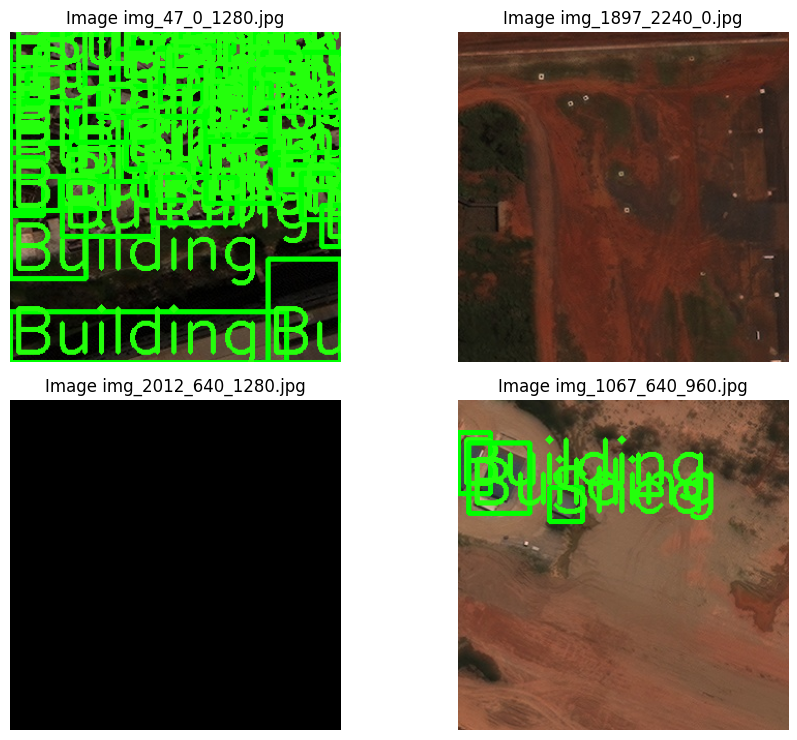

In [27]:
filenames = [x for x in os.listdir(save_images_fldr_pth) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, save_images_fldr_pth, max_images=4, no_cols=2, text=True,  class_map=class_map_dict)

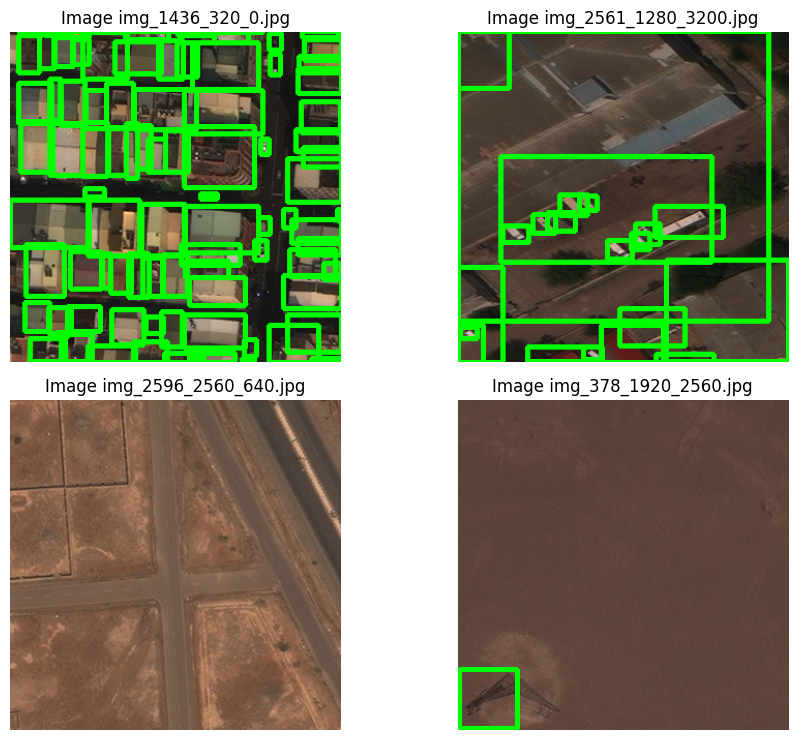

In [28]:
#without text labels
filenames = [x for x in os.listdir(save_images_fldr_pth) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, save_images_fldr_pth, max_images=4, no_cols=2, text=False)

## Splitting

In [29]:
total_images = len(filenames)
indices = list(range(total_images))
random.shuffle(indices)

train_fraction = 1 - TEST_FRACTION - VAL_FRACTION
train_sp = int(np.floor(train_fraction * len(indices))) # The training-validation split
valid_sp = int(np.floor(VAL_FRACTION * len(indices))) + train_sp # The validation-test split
train_idx, val_idx, test_idx = indices[:train_sp], indices[train_sp:valid_sp], indices[valid_sp:]

print(' Training set size: \t', len(train_idx))
print(' Validation set size: \t', len(val_idx))
print(' Test set size: \t', len(test_idx))
print(' Total dataset: \t', total_images)

 Training set size: 	 36712
 Validation set size: 	 4589
 Test set size: 	 4590
 Total dataset: 	 45891


Write 3 text files into the Data folder with the file paths: train.txt, val.txt, test.txt  These are lists of absolute filepaths to the images, one line each path.  They can reside anywhere just so long as the relative paths in xview_yolo.yaml points to them.

In [30]:
files = ['train.txt', 'val.txt', 'test.txt']
splits = [train_idx, val_idx, test_idx]

for fn, split in zip(files, splits):
    txt_pth = cfg_fldr_pth / fn
    with open(txt_pth, 'a') as f:
        for ind in split:
            f.write(str(future_ds_img_fldr / filenames[ind]) + '\n')
        print(f'{fn[:-4]} file written to {txt_pth}, with {len(split) } samples')

train file written to /kaggle/working/YOLO_cfg/train.txt, with 36712 samples
val file written to /kaggle/working/YOLO_cfg/val.txt, with 4589 samples
test file written to /kaggle/working/YOLO_cfg/test.txt, with 4590 samples


## YAML File
Write a .yaml file pointing to the text file locations, and determining class names, number of categories location.
This is good practice, it means I don't need to move all the image files around just to change the training splits.
Also the .yml file gets updated automatically if anybody changes something like the number of classes.

In [31]:
config = {'train': str(future_ds_cfg_fldr / files[0]),
          'val': str(future_ds_cfg_fldr / files[1]),
          'test': str(future_ds_cfg_fldr / files[2]),
          'nc': len(class_map_dict),
          'names': class_map_dict
          }

with open(yolo_yaml_pth, "w") as file:
    yaml.dump(config, file, default_style=None, default_flow_style=False, sort_keys=False)
print(f'yaml file written to {yolo_yaml_pth}')

yaml file written to /kaggle/working/YOLO_cfg/xview_yolo.yaml


## Splitting Check
Just checking the first few lines of the train.txt file

In [32]:
for split in ['train', 'val', 'test']:
    print(f'{split} text file')
    print_first_n_lines(cfg_fldr_pth / f'{split}.txt', 2)

train text file
/kaggle/working/images/img_144_1600_1920.jpg
/kaggle/working/images/img_1529_320_0.jpg
val text file
/kaggle/working/images/img_1523_1600_1600.jpg
/kaggle/working/images/img_2550_0_1600.jpg
test text file
/kaggle/working/images/img_1817_2560_960.jpg
/kaggle/working/images/img_105_0_320.jpg


And the .yaml file

In [33]:
print_first_n_lines(yolo_yaml_pth, 10)

train: /kaggle/working/YOLO_cfg/train.txt
val: /kaggle/working/YOLO_cfg/val.txt
test: /kaggle/working/YOLO_cfg/test.txt
nc: 60
names:
0: Fixed-wing Aircraft
1: Small Aircraft
2: Passenger/Cargo Plane
3: Helicopter
4: Passenger Vehicle


And a couple of annotations files

In [34]:
txt_fnames = [save_images_fldr_pth / x for x in os.listdir(save_images_fldr_pth) if x.endswith(".txt")]
text_list = random.choices(txt_fnames, k=2)
print(text_list)
for text_f in text_list:
    print(f'Reading {text_f}')
    print_first_n_lines(text_f, 3)  

[PosixPath('/kaggle/working/images/img_884_2240_640.txt'), PosixPath('/kaggle/working/images/img_1378_640_640.txt')]
Reading /kaggle/working/images/img_884_2240_640.txt
5 0.85938 0.13281 0.04375 0.02813
4 0.97031 0.98281 0.03438 0.03438
53 0.87188 0.9875 0.25625 0.025
Reading /kaggle/working/images/img_1378_640_640.txt
23 0.11562 0.875 0.23125 0.25
23 0.15625 0.88125 0.14375 0.19375
23 0.16719 0.05 0.33438 0.1


In [35]:
print(text_list)

[PosixPath('/kaggle/working/images/img_884_2240_640.txt'), PosixPath('/kaggle/working/images/img_1378_640_640.txt')]


And the csv file

In [36]:
out_data = pd.read_parquet(out_data_parquet_pth)
out_data.head()

,File_Name,Class_Name,Class_ID,x_center,y_center,width,height
0,img_89_1920_0.txt,Building,48,0.06719,0.60938,0.13438,0.1125
1,img_89_1920_0.txt,Building,48,0.23438,0.87656,0.1375,0.17188
2,img_89_1920_0.txt,Small Car,5,0.3125,0.69844,0.05,0.03437
3,img_89_1920_0.txt,Small Car,5,0.32812,0.72031,0.05,0.03438
4,img_89_1920_0.txt,Small Car,5,0.34844,0.73438,0.04063,0.0375


In [37]:
# Conta il numero di immagini con nomi unici
num_immagini_uniche = out_data['File_Name'].nunique()
print(f"Il numero di immagini uniche è: {num_immagini_uniche}")

Il numero di immagini uniche è: 32194


And the `.json`

In [38]:
with open(out_json_map_pth, "r") as json_file:
    loaded_dict = json.load(json_file)
print(loaded_dict)

{'0': 'Fixed-wing Aircraft', '1': 'Small Aircraft', '2': 'Passenger/Cargo Plane', '3': 'Helicopter', '4': 'Passenger Vehicle', '5': 'Small Car', '6': 'Bus', '7': 'Pickup Truck', '8': 'Utility Truck', '9': 'Truck', '10': 'Cargo Truck', '11': 'Truck Tractor w/ Box Trailer', '12': 'Truck Tractor', '13': 'Trailer', '14': 'Truck Tractor w/ Flatbed Trailer', '15': 'Truck Tractor w/ Liquid Tank', '16': 'Crane Truck', '17': 'Railway Vehicle', '18': 'Passenger Car', '19': 'Cargo/Container Car', '20': 'Flat Car', '21': 'Tank car', '22': 'Locomotive', '23': 'Maritime Vessel', '24': 'Motorboat', '25': 'Sailboat', '26': 'Tugboat', '27': 'Barge', '28': 'Fishing Vessel', '29': 'Ferry', '30': 'Yacht', '31': 'Container Ship', '32': 'Oil Tanker', '33': 'Engineering Vehicle', '34': 'Tower crane', '35': 'Container Crane', '36': 'Reach Stacker', '37': 'Straddle Carrier', '38': 'Mobile Crane', '39': 'Dump Truck', '40': 'Haul Truck', '41': 'Scraper/Tractor', '42': 'Front loader/Bulldozer', '43': 'Excavator',

## YOLO to COCO

Poiché non richiede molto sforzo in questo momento, riformatterò il dataframe nella geometria del formato COCO e scriverò un file `.json` in formato COCO per coloro che necessitano di tale formato. Il formato COCO è spiegato [qui](https://cocodataset.org/#format-data). A livello superiore, abbiamo principalmente bisogno di questi tre oggetti:

- **images:**  
  `{"id": int, "width": int, "height": int, "file_name": str, }`  

- **annotations:**  
  `{"id": int, "image_id": int, "category_id": int, "area": float, "bbox": [x, y, width, height]}`  

- **categories:**  
  `[{"id": int, "name": str}]`

Copiamo il DataFrame YOLO, per estrarre le larghezze delle immagini e creare la categoria BBox

In [39]:
num_file_names = len(image_data) # Il numero di chiavi corrisponde al numero di file_names (per ora)
num_widths = len([value[0] for value in image_data.values()])  # Conta tutte le larghezze
num_heights = len([value[1] for value in image_data.values()])  # Conta tutte le altezze

print(f"Il numero di immagini uniche è: {num_file_names}")
print(f"Il numero di larghezze registrate è: {num_widths}")
print(f"Il numero di altezze registrate è: {num_heights}")

Il numero di immagini uniche è: 45891
Il numero di larghezze registrate è: 45891
Il numero di altezze registrate è: 45891


In [40]:
image_data = {'width': filtered_widths, 'height': filtered_heights, 'file_name': filtered_file_names} # Ricreo il dizionario con 3 chiavi ma utilizzando le liste filtraten dopo l'eliminazione fatta prima
im_df = pd.DataFrame(image_data)
im_df['id'] = im_df['file_name'].str.replace(r'\D', '', regex=True).astype(int)
im_df.head()

,width,height,file_name,id
0,320,320,img_2355_0_0.jpg,235500
1,320,320,img_2355_0_960.jpg,23550960
2,320,320,img_2355_0_1280.jpg,235501280
3,320,320,img_2355_0_1600.jpg,235501600
4,320,320,img_2355_0_1920.jpg,235501920


In [41]:
num_file_names = len(image_data['file_name'])  # Numero di file rimanenti
num_widths = len(image_data['width'])         # Numero di larghezze rimanenti
num_heights = len(image_data['height'])       # Numero di altezze rimanenti

print(f"Il numero di immagini uniche è: {num_file_names}")
print(f"Il numero di larghezze registrate è: {num_widths}")
print(f"Il numero di altezze registrate è: {num_heights}")

Il numero di immagini uniche è: 45891
Il numero di larghezze registrate è: 45891
Il numero di altezze registrate è: 45891


In [42]:
num_images_in_im_df = len(im_df)
print(f"Numero di immagini in im_df: {num_images_in_im_df}")

Numero di immagini in im_df: 45891


In [43]:
def row_to_dict(row):
    return {
        'id': row['id'],
        'width': row['width'],
        'height':row['height'],
        'file_name':row['file_name']
    }

im_list = im_df.apply(lambda row: row_to_dict(row), axis=1).tolist()
[print(val) for val in im_list[:4]]

{'id': 235500, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_0.jpg'}
{'id': 23550960, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_960.jpg'}
{'id': 235501280, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_1280.jpg'}
{'id': 235501600, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_1600.jpg'}


[None, None, None, None]

Merge the images dataframe with the annotations to work out the absolute pixel values, plus a bit more re-organising.

In [44]:
annotations_df = out_data.copy()
annotations_df['image_id'] = annotations_df['File_Name'].str.replace(r'\D', '', regex=True).astype(int)
annotations_df= annotations_df.rename(columns={'height': 'h', 'width': 'w'})
an_df = annotations_df.merge(im_df, left_on='image_id', right_on='id', how='left')
an_df['x_center']= (an_df['x_center'].astype(np.float64)*an_df['width']).round(decimals=0)
an_df['y_center']= (an_df['y_center'].astype(np.float64)*an_df['height']).round(decimals=0)
an_df['w']= (an_df['w'].astype(np.float64)*an_df['width']).round(decimals=0)
an_df['h']= (an_df['h'].astype(np.float64)*an_df['height']).round(decimals=0)
an_df['Class_ID']= an_df['Class_ID'].astype(int)
an_df = an_df.drop(columns=['File_Name', 'file_name', 'width', 'height', 'id'])
an_df['left'] = (an_df['x_center'] - an_df['w']/2).round(decimals=0)
an_df['top'] =  (an_df['y_center'] - an_df['h']/2).round(decimals=0)
an_df['bbox'] = ('[' + an_df['left'].astype(str) + ', ' 
              + an_df['top'].astype(str) + ', ' 
              + an_df['w'].astype(str) + ', '
              + an_df['h'].astype(str) + ']')
an_df['area'] = an_df['w'] * an_df['h']
an_df = an_df.drop(columns=['x_center', 'y_center', 'w', 'h', 'left', 'top', 'Class_Name'])
an_df.reset_index(inplace=True)
an_df.rename(columns={'index': 'id'}, inplace=True)
an_df.head()

,id,Class_ID,image_id,bbox,area
0,0,48,8919200,"[0.0, 177.0, 43.0, 36.0]",1548.0
1,1,48,8919200,"[53.0, 252.0, 44.0, 55.0]",2420.0
2,2,5,8919200,"[92.0, 218.0, 16.0, 11.0]",176.0
3,3,5,8919200,"[97.0, 224.0, 16.0, 11.0]",176.0
4,4,5,8919200,"[106.0, 229.0, 13.0, 12.0]",156.0


In [45]:
def row_to_dict(row):
    return {
        'id': row['id'],
        'image_id' : row['image_id'],
        'category_id': row['Class_ID'],
        'area':row['area'],
        'bbox':row['bbox']
    }

an_list = an_df.apply(lambda row: row_to_dict(row), axis=1).tolist()
print(an_list[:4])

[{'id': 0, 'image_id': 8919200, 'category_id': 48, 'area': 1548.0, 'bbox': '[0.0, 177.0, 43.0, 36.0]'}, {'id': 1, 'image_id': 8919200, 'category_id': 48, 'area': 2420.0, 'bbox': '[53.0, 252.0, 44.0, 55.0]'}, {'id': 2, 'image_id': 8919200, 'category_id': 5, 'area': 176.0, 'bbox': '[92.0, 218.0, 16.0, 11.0]'}, {'id': 3, 'image_id': 8919200, 'category_id': 5, 'area': 176.0, 'bbox': '[97.0, 224.0, 16.0, 11.0]'}]


The category mapping is just about in a convenient format already

In [46]:
cat_list = [{key:val} for key,val in class_map_dict.items()]
print(cat_list[:4])

[{0: 'Fixed-wing Aircraft'}, {1: 'Small Aircraft'}, {2: 'Passenger/Cargo Plane'}, {3: 'Helicopter'}]


Now I just need to combine the top level objects, and save to `.json`

In [47]:
out_json_data = {'images': im_list, 'annotations': an_list, 'categories': cat_list}
with open(coco_json_pth, 'w') as json_file:
    json.dump(out_json_data, json_file, indent=4)
    
for key, value in out_json_data.items():
    print(key, value[:5])

images [{'id': 235500, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_0.jpg'}, {'id': 23550960, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_960.jpg'}, {'id': 235501280, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_1280.jpg'}, {'id': 235501600, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_1600.jpg'}, {'id': 235501920, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_1920.jpg'}]
annotations [{'id': 0, 'image_id': 8919200, 'category_id': 48, 'area': 1548.0, 'bbox': '[0.0, 177.0, 43.0, 36.0]'}, {'id': 1, 'image_id': 8919200, 'category_id': 48, 'area': 2420.0, 'bbox': '[53.0, 252.0, 44.0, 55.0]'}, {'id': 2, 'image_id': 8919200, 'category_id': 5, 'area': 176.0, 'bbox': '[92.0, 218.0, 16.0, 11.0]'}, {'id': 3, 'image_id': 8919200, 'category_id': 5, 'area': 176.0, 'bbox': '[97.0, 224.0, 16.0, 11.0]'}, {'id': 4, 'image_id': 8919200, 'category_id': 5, 'area': 156.0, 'bbox': '[106.0, 229.0, 13.0, 12.0]'}]
categories [{0: 'Fixed-wing Aircraft'}, {1: 'Small Ai

## Check Image Sizes

In [48]:
def check_image_sizes(directory_path):
    size_counts = defaultdict(int)

    # Ottieni la lista dei file nella cartella
    files = [f for f in os.listdir(directory_path) if f.endswith(('.jpg'))]

    # Aggiungi una barra di progresso per iterare sui file
    for filename in tqdm(files, desc="Processing images"):
        img_path = os.path.join(directory_path, filename)
        with Image.open(img_path) as img:
            size = img.size  # (width, height)
            size_counts[size] += 1

    # Crea gruppi per le dimensioni richieste
    size_groups = {
        'Smaller than 320x320': [],
        '320x320': [],
        'Larger than 320x320': [],
    }

    # Aggiungi le dimensioni agli appropriate gruppi
    for size, count in size_counts.items():
        width, height = size
        if width < 320 and height < 320:
            size_groups['Smaller than 320x320'].append((size, count))
        elif width == 320 and height == 320:
            size_groups['320x320'].append((size, count))
        elif width > 320 and height > 320:
            size_groups['Larger than 320x320'].append((size, count))

    # Ordina le dimensioni per area (larghezza * altezza) in ordine decrescente
    for group, items in size_groups.items():
        sorted_items = sorted(items, key=lambda x: x[0][0] * x[0][1], reverse=True)  # ordina per area
        size_groups[group] = sorted_items

    # Stampa i gruppi con il numero di immagini per dimensione e il totale per intervallo
    for group, items in size_groups.items():
        total = sum(count for _, count in items)
        print(f"{group} (Totale: {total} immagini):")
        for size, count in items:
            print(f"  Dimensione {size}: {count} immagini")
        print()

# Esegui la funzione con il percorso della cartella
check_image_sizes(save_images_fldr_pth)

Processing images: 100%|██████████| 45891/45891 [00:14<00:00, 3103.12it/s]

Smaller than 320x320 (Totale: 0 immagini):

320x320 (Totale: 45891 immagini):
  Dimensione (320, 320): 45891 immagini

Larger than 320x320 (Totale: 0 immagini):



In [49]:
with open(coco_json_pth, 'r') as f:
    coco_data = json.load(f)

In [50]:
def check_image_size(image, img_id, coco_data):
    # Trova le dimensioni dell'immagine nel JSON
    image_info = next((img for img in coco_data['images'] if img['id'] == img_id), None)
    if image_info:
        width, height = image_info['width'], image_info['height']
        img_width, img_height = image.size
        # Lancia un'eccezione solo se le dimensioni non corrispondono
        assert img_width == width and img_height == height, (
            f"Dimensioni errate: JSON ({width}, {height}), immagine ({img_width}, {img_height})"
        )
    else:
        raise ValueError(f"Immagine con ID {img_id} non trovata nel JSON.")

def check_all_images(folder_path, coco_data):
    folder_path = Path(folder_path)
    errors_found = False  # Flag per tenere traccia degli errori
    check_count = 0  # Conta il numero di immagini verificate
    
    # Itera attraverso tutti i file nella cartella
    for image_path in folder_path.iterdir():
        if image_path.is_file() and image_path.suffix in ['.jpg']:  # Controlla solo file immagine
            check_count += 1  # Incrementa il contatore delle immagini
            # Trova l'ID corrispondente basato sul nome file
            img_id = int(''.join(filter(str.isdigit, image_path.stem)))  # Estrae i numeri dal nome
            try:
                with Image.open(image_path) as img:
                    check_image_size(img, img_id, coco_data)
            except (AssertionError, ValueError) as e:
                errors_found = True
                print(f"Errore per immagine {image_path.name}: {e}")
            except Exception as e:
                errors_found = True
                print(f"Errore generico per immagine {image_path.name}: {e}")

    # Stampa il risultato finale
    if not errors_found:
        print(f"Check completato, nessun errore trovato. Numero di immagini verificate: {check_count}")
    else:
        print(f"Check completato con errori. Numero di immagini verificate: {check_count}")

# Percorso alla directory delle immagini
check_all_images(save_images_fldr_pth, coco_data)

Check completato, nessun errore trovato. Numero di immagini verificate: 45891


## Check Labels

In [51]:
def check_empty_txt_files(directory_path):
    # Ottieni tutti i file .txt nella cartella
    txt_files = [f for f in os.listdir(directory_path) if f.endswith(".txt")]
    
    empty_files_count = 0
    total_lines = 0
    non_empty_files_count = 0
    
    # Controlla se ogni file è vuoto
    for txt_file in txt_files:
        file_path = os.path.join(directory_path, txt_file)
        if os.path.getsize(file_path) == 0:
            empty_files_count += 1
        else:
            non_empty_files_count += 1
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_lines += len(lines)
    
    # Calcola la media delle righe per i file non vuoti
    avg_lines = total_lines / non_empty_files_count if non_empty_files_count > 0 else 0
    
    # Stampa il numero di file vuoti e la media delle righe nei file non vuoti
    print(f"Numero di file .txt vuoti: {empty_files_count}")
    print(f"Numero di file .txt non vuoti: {non_empty_files_count}")
    print(f"Media delle righe per file non vuoto: {avg_lines:.2f}")

check_empty_txt_files(save_images_fldr_pth)

Numero di file .txt vuoti: 13697
Numero di file .txt non vuoti: 32194
Media delle righe per file non vuoto: 20.75


## Category Distribution

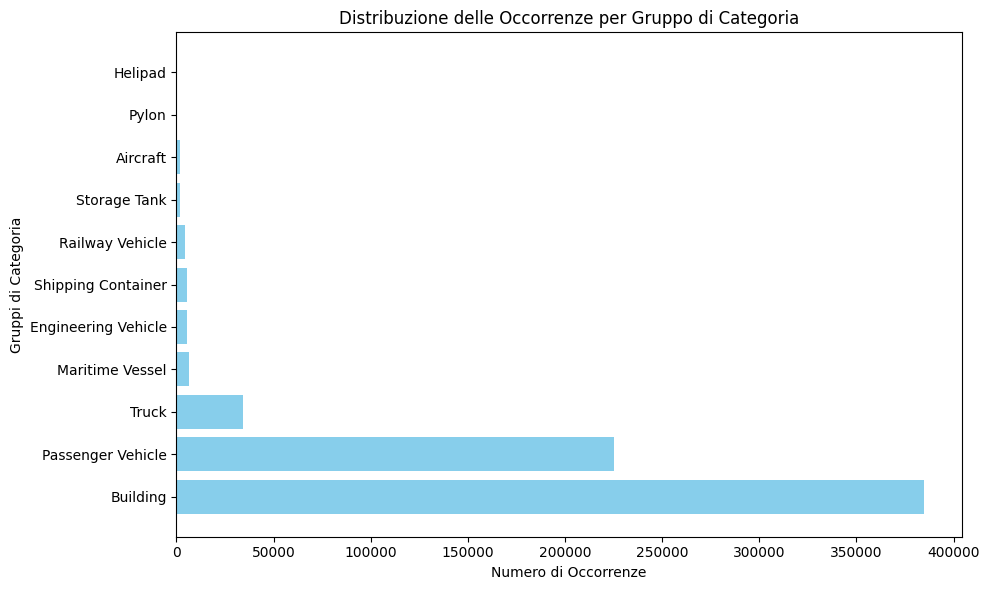

Gruppo: Helipad, Occorrenze Totali: 152
  category_id: 54, Categoria: Helipad, Occorrenze: 152


Gruppo: Pylon, Occorrenze Totali: 470
  category_id: 58, Categoria: Pylon, Occorrenze: 470


Gruppo: Aircraft, Occorrenze Totali: 1708
  category_id: 0, Categoria: Fixed-wing Aircraft, Occorrenze: 95
  category_id: 1, Categoria: Small Aircraft, Occorrenze: 407
  category_id: 2, Categoria: Passenger/Cargo Plane, Occorrenze: 1129
  category_id: 3, Categoria: Helicopter, Occorrenze: 77


Gruppo: Storage Tank, Occorrenze Totali: 2033
  category_id: 55, Categoria: Storage Tank, Occorrenze: 2033


Gruppo: Railway Vehicle, Occorrenze Totali: 4233
  category_id: 17, Categoria: Railway Vehicle, Occorrenze: 19
  category_id: 18, Categoria: Passenger Car, Occorrenze: 1758
  category_id: 19, Categoria: Cargo/Container Car, Occorrenze: 2036
  category_id: 20, Categoria: Flat Car, Occorrenze: 150
  category_id: 21, Categoria: Tank car, Occorrenze: 129
  category_id: 22, Categoria: Locomotive, Occorrenze:

In [52]:
with open(coco_json_pth, 'r') as f:
    coco_data = json.load(f)

# Crea un dizionario per mappare category_id a categoria
category_mapping = {str(index): list(category.values())[0] for index, category in enumerate(coco_data['categories'])}

# Estrai i category_id dalle annotazioni
category_ids = [annotation['category_id'] for annotation in coco_data['annotations']]

# Conta le occorrenze di ogni category_id
category_counts = Counter(category_ids)

# Gruppi delle categorie
category_groups = {
    "Aircraft": [0, 1, 2, 3],
    "Passenger Vehicle": [4, 5, 6, 53],
    "Truck": [7, 8, 9, 10, 11, 12, 13, 14, 15],
    "Railway Vehicle": [17, 18, 19, 20, 21, 22],
    "Maritime Vessel": [23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    "Engineering Vehicle": [16, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
    "Building": [46, 47, 48, 49, 50, 51, 52, 59],
    "Helipad": [54],
    "Storage Tank": [55],
    "Shipping Container": [56, 57],
    "Pylon": [58],
}

# Crea un dizionario per le categorie aggregate con le loro occorrenze
grouped_occurrences = {}
for group_name, category_ids in category_groups.items():
    # Somma le occorrenze per le categorie di ogni gruppo
    grouped_occurrences[group_name] = sum(category_counts[cat_id] for cat_id in category_ids)

# Ordina le categorie raggruppate per occorrenze in ordine decrescente
grouped_occurrences = dict(sorted(grouped_occurrences.items(), key=lambda item: item[1], reverse=True))

# Prepara i dati per il grafico
groups = list(grouped_occurrences.keys())
occurrences = list(grouped_occurrences.values())


# Crea il grafico a barre
plt.figure(figsize=(10, 6))
plt.barh(groups, occurrences, color='skyblue')
plt.xlabel('Numero di Occorrenze')
plt.ylabel('Gruppi di Categoria')
plt.title('Distribuzione delle Occorrenze per Gruppo di Categoria')
plt.tight_layout()

# Mostra il grafico
plt.show()

# Stampare le occorrenze per ciascun group e i relativi ID
sorted_groups = sorted(category_groups.items(), key=lambda item: sum(category_counts.get(cat_id, 0) for cat_id in item[1]))

for group, category_ids in sorted_groups:
    # Calcola il numero totale di occorrenze per il gruppo
    total_count = sum(category_counts.get(cat_id, 0) for cat_id in category_ids)
    
    print(f"Gruppo: {group}, Occorrenze Totali: {total_count}")
    
    for cat_id in category_ids:
        category_name = category_mapping[str(cat_id)]
        count = category_counts.get(cat_id, 0)
        print(f"  category_id: {cat_id}, Categoria: {category_name}, Occorrenze: {count}")
    
    print("\n")

In [53]:
new_coco_json_pth = out_dataset_pth / 'COCO_annotations_new.json'

In [54]:
# Carica il file COCO originale
with open(coco_json_pth, 'r') as f:
    coco_data = json.load(f)

# Creare nuove categorie nel formato richiesto
new_categories = [{str(idx): group} for idx, group in enumerate(category_groups.keys())]

# Mappatura inversa dei gruppi (vecchio category_id -> nuovo group_id)
group_mapping = {}
for group_id, (group_name, category_ids) in enumerate(category_groups.items(), start=0):
    for cat_id in category_ids:
        group_mapping[cat_id] = group_id

# Aggiorna i category_id nelle annotazioni
for annotation in coco_data["annotations"]:
    original_id = annotation["category_id"]
    annotation["category_id"] = group_mapping.get(original_id, -1)  # Usa -1 per eventuali category_id non mappati

# Verifica annotazioni non mappate
unmapped = [ann for ann in coco_data["annotations"] if ann["category_id"] == -1]
if unmapped:
    print(f"Attenzione: {len(unmapped)} annotazioni con category_id non mappati.")

# Aggiorna il dizionario delle categorie
coco_data["categories"] = new_categories

# Salva il file COCO modificato
new_coco_json_pth = Path(out_dataset_pth) / 'COCO_annotations_new.json'
with open(new_coco_json_pth, "w") as f:
    json.dump(coco_data, f, indent=4)

print(f"File COCO modificato salvato in {new_coco_json_pth}.")

File COCO modificato salvato in /kaggle/working/COCO_annotations_new.json.


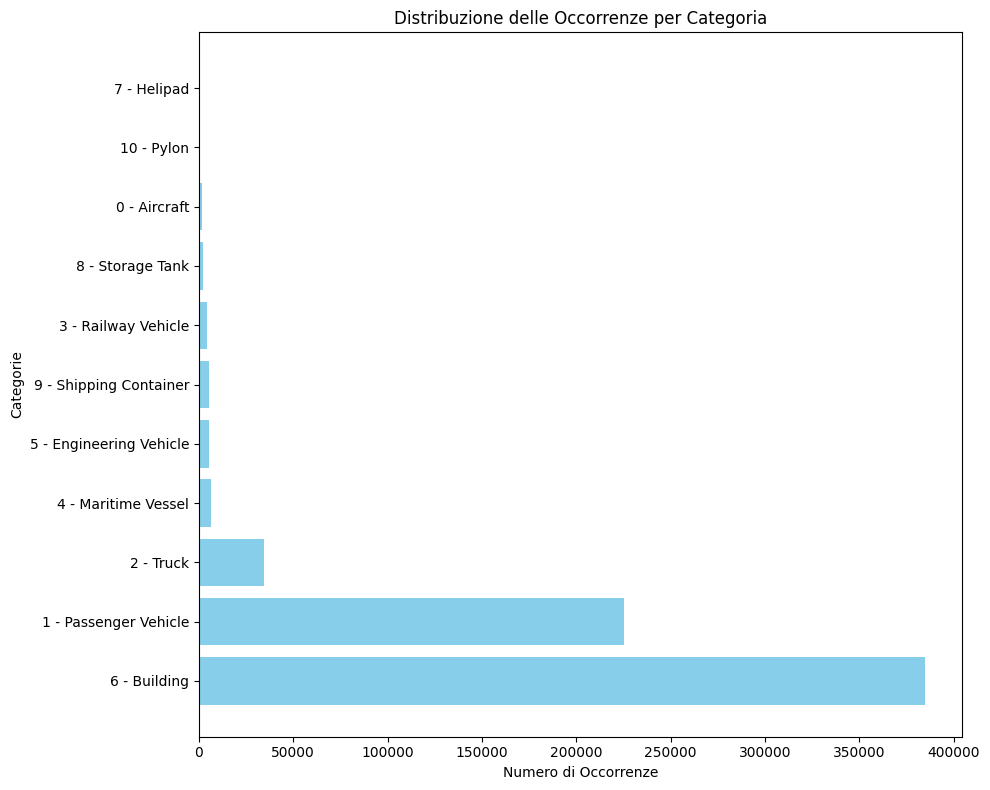

Categoria ID: 6, Nome: Building, Occorrenze: 384921
Categoria ID: 1, Nome: Passenger Vehicle, Occorrenze: 225106
Categoria ID: 2, Nome: Truck, Occorrenze: 34392
Categoria ID: 4, Nome: Maritime Vessel, Occorrenze: 6332
Categoria ID: 5, Nome: Engineering Vehicle, Occorrenze: 5474
Categoria ID: 9, Nome: Shipping Container, Occorrenze: 5406
Categoria ID: 3, Nome: Railway Vehicle, Occorrenze: 4233
Categoria ID: 8, Nome: Storage Tank, Occorrenze: 2033
Categoria ID: 0, Nome: Aircraft, Occorrenze: 1708
Categoria ID: 10, Nome: Pylon, Occorrenze: 470
Categoria ID: 7, Nome: Helipad, Occorrenze: 152


In [55]:
# Carica il file COCO modificato
with open(new_coco_json_pth, 'r') as f:
    coco_data = json.load(f)

# Crea un dizionario per mappare category_id a nome della categoria dal nuovo formato
category_mapping = {
    int(list(category.keys())[0]): list(category.values())[0]
    for category in coco_data["categories"]
}

# Estrai i category_id dalle annotazioni
category_ids = [annotation["category_id"] for annotation in coco_data["annotations"]]

# Conta le occorrenze di ogni category_id
category_counts = Counter(category_ids)

# Associa i nomi delle categorie alle loro occorrenze
category_occurrences = {
    cat_id: (category_mapping[cat_id], count)
    for cat_id, count in category_counts.items()
    if cat_id in category_mapping
}

# Ordina le categorie per occorrenze in ordine decrescente
category_occurrences = dict(sorted(category_occurrences.items(), key=lambda item: item[1][1], reverse=True))

# Prepara i dati per il grafico
categories = [f"{cat_id} - {name}" for cat_id, (name, _) in category_occurrences.items()]
occurrences = [count for _, (_, count) in category_occurrences.items()]

# Crea il grafico a barre
plt.figure(figsize=(10, 8))
plt.barh(categories, occurrences, color="skyblue")
plt.xlabel("Numero di Occorrenze")
plt.ylabel("Categorie")
plt.title("Distribuzione delle Occorrenze per Categoria")
plt.tight_layout()

# Mostra il grafico
plt.show()

# Stampa le occorrenze per ogni categoria con ID
for cat_id, (name, count) in category_occurrences.items():
    print(f"Categoria ID: {cat_id}, Nome: {name}, Occorrenze: {count}")

In [56]:
import zipfile
import os

working_dir = "/kaggle/working"

# Nome del file zip da creare
zip_file_name = "our-xview-dataset.zip"

# Elenco di file e cartelle da includere nello zip
items_to_zip = [
    "COCO_annotations.json",
    "YOLO_cfg",  # Cartella
    "images",    # Cartella
    "xView_class_map.json",
    "xview_labels.parquet"
]

# Funzione per aggiungere file e cartelle allo zip
def zip_folder(zipf, folder_path, base_folder=""):
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, base_folder)
            zipf.write(file_path, arcname)

# Creazione dello zip
with zipfile.ZipFile(zip_file_name, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for item in items_to_zip:
        if os.path.exists(item):  # Verifica che il file o la cartella esista
            if os.path.isdir(item):  # Se è una cartella, aggiungi tutto il contenuto
                zip_folder(zipf, item, working_dir)
            else:  # Se è un file, aggiungilo direttamente
                zipf.write(item)
        else:
            print(f"Elemento non trovato: {item}")

In [57]:
# Directory da pulire
working_dir = "/kaggle/working"

# Nome del file da escludere
exclude_file = "our-xview-dataset.zip"

# Scorri tutti gli elementi nella directory
for item_name in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item_name)
    
    # Controlla se è un file e non è quello da escludere
    if os.path.isfile(item_path) and item_name != exclude_file:
        os.remove(item_path)
        print(f"Eliminato file: {item_path}")
    
    # Controlla se è una directory e la elimina
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)
        print(f"Eliminata cartella: {item_path}")

print("Pulizia completata!")

Eliminata cartella: /kaggle/working/images
Eliminato file: /kaggle/working/COCO_annotations.json
Eliminato file: /kaggle/working/xView_class_map.json
Eliminato file: /kaggle/working/xview_labels.parquet
Eliminato file: /kaggle/working/__notebook__.ipynb
Eliminata cartella: /kaggle/working/YOLO_cfg
Eliminato file: /kaggle/working/COCO_annotations_new.json
Pulizia completata!


# **Modelli**
Modelli scelti:
* [R-CNN con backbone AlexNet](https://medium.com/@selfouly/r-cnn-3a9beddfd55a)
* [SPPNet con backbone ZF-5](https://arxiv.org/pdf/1406.4729)
* [Faster R-CNN con backbone ResNet50](https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3)